In [2]:
import numpy as np
import scipy.sparse as sps
from math import ceil, floor, log10, exp, isnan
import os, shutil, sys

import porepy as pp
import pygeon as pg

import matplotlib.pyplot as plt

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


In [3]:
import utilities.chi_func as helper_chi_func
from utilities.moving_darcy.stifness_matrix import stifness
from utilities.moving_darcy.mass_matrix import global_mass

In [4]:
output_directory = 'primal'

### Parameters

In [5]:
T = 1
dt = 0.1

In [6]:
infiltration_rate = 1e-3
extraction_rate = 0.3

In [7]:
S_s = 0.1
phi = 0.1

In [8]:
N = 40 # 16
quad_order = 3

In [9]:
abs_tol = 1e-5
rel_tol = 1e-5
max_iterations_per_step = 100

### Grid and $V_h$

In [10]:
# convert the grid into a mixed-dimensional grid
sd = pp.StructuredTriangleGrid([N, N], [1, 1])
sd.compute_geometry()
pg.convert_from_pp(sd)

In [38]:
# Estrapolates the boundary grid
boundary_grid, boundary_face_map, boundary_node_map = pp.partition.extract_subgrid(sd, sd.face_centers[1, :] == 1, faces=True)

In [12]:
mdg = pg.as_mdg(sd)

In [13]:
subdomain, data = mdg.subdomains( return_data=True )[0]

In [14]:
key = "flow"

darcy_data = {}
initial_pressure = []

In [15]:
h_field     = pg.Lagrange1(key)
gamma_field = pg.Lagrange1(key)

In [16]:
subdomain, data = mdg.subdomains(return_data=True)[0]

In [17]:
def h_bc(x, t): return 1
def initial_h_func(x): return 1
def infiltration(x, t): return infiltration_rate

In [18]:
eta_mask = sd.nodes[1, :] == 1

In [19]:
dof_p = h_field.ndof(subdomain)

### Mapping

In [20]:
# Construct the transformation Chi. In this case, it will be a linear function \chi(\bm{x}, t) = \bm{x}_3*\eta(\bm{x}_{\parallel}, t)
chi_func = helper_chi_func.Linear_Chi(A=2)
chi_x3  = lambda eta, x3: chi_func.x3_derivative(eta, x3)
chi_eta = lambda eta, x3: chi_func.eta_derivative(eta, x3)

In [21]:
# Maps the heights on the reference domain to the physical one
def convert_heights(eta_dofs, heights):
    if len(eta_dofs) == len(heights):
        return chi_func(eta_dofs, heights)
    else:
        return chi_func( np.tile(eta_dofs, ceil(len(heights) / len(eta_dofs))) , heights)

### BC

##### Dirichlet (essential)

In [22]:
dirichlet_flag = sd.nodes[0, :] == 1

In [23]:
dirichlet_value = np.array(dirichlet_flag, dtype=float)

##### Neumann (natural)

In [24]:
neumann_condition = -h_field.assemble_nat_bc(subdomain, lambda x: extraction_rate, np.where(subdomain.face_centers[0, :] == 0)[0])

### Matrix Assembly

In [25]:
eta_diff = gamma_field.assemble_diff_matrix( boundary_grid )
eta_diff[0,0] = -1
eta_diff *= N

In [26]:
M_gamma = gamma_field.assemble_mass_matrix( boundary_grid )
M_h = h_field.assemble_mass_matrix(subdomain)

#### Restrictor matrices

In [27]:
# Helper matrices used to restrict the degrees of freedom of h to the ones at the boundary
restrict_eta = np.array(eta_mask, dtype=float)
restrict_eta = sps.csr_matrix(np.diag(restrict_eta, k=0))

In [28]:
upscale_to_h = np.zeros(shape=(sd.num_nodes, boundary_grid.num_nodes))
upscale_to_h[ eta_mask , np.arange(boundary_grid.num_nodes) ] = 1
upscale_to_h = sps.csr_matrix(upscale_to_h)

In [29]:
proj_psi = h_field.eval_at_cell_centers(subdomain)

### Solve System

In [30]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [31]:
# Fixed rhs
fixed_rhs = np.zeros(dof_p)

In [32]:
# Initial conditions
sol = [h_field.interpolate(sd, initial_h_func)]

In [33]:
def save_step(sol, saver, i):
    ins = list()

    ins.append((sd, "cell_h", proj_psi @ sol))

    saver.write_vtu(ins, time_step=i)

In [34]:
# Save the initial solution
saver = pp.Exporter(mdg, 'sol', folder_name=output_directory)
save_step(sol[-1], saver, 0)

In [35]:
csv_base = os.path.join(output_directory, 'csv')
os.mkdir( csv_base )

In [36]:
# Time Loop
for i in range(1, int(T/dt)+1):
    print('Time ' + str(i * dt))
    current_time = i * dt

    # Prepare the solution at the previous time step and ...
    prev = sol[-1].copy()

    # Prepare the rhs
    time_rhs = fixed_rhs.copy()

    debug_saver = pp.Exporter(mdg, str(i) + '_sol', folder_name=os.path.join(output_directory, 'debug'))
    save_step(sol[-1], debug_saver, 0)
    
    # Non-linear loop
    for k in range(max_iterations_per_step):
        A_h = stifness(eta_diff, subdomain, boundary_grid, 
                           prev[eta_mask],
                           quad_order, chi_func)
        
        # Assemble the saddle point problem
        glob_mass = global_mass(subdomain, boundary_grid, prev[eta_mask], quad_order, chi_func, correction=True)
        spp = sps.csr_matrix(S_s / dt * glob_mass + phi / dt * upscale_to_h @ M_gamma @ upscale_to_h.T + A_h)

        # Prepare the solver
        rhs = time_rhs.copy()
        rhs += phi / dt * upscale_to_h @ M_gamma @ sol[-1][eta_mask] #/ prev[eta_mask][0]
        rhs += upscale_to_h @ M_gamma @ gamma_field.interpolate( boundary_grid, lambda x: infiltration(x, current_time))
        rhs += neumann_condition
        rhs += S_s / dt * glob_mass @ sol[-1]

        ls = pg.LinearSystem(spp, rhs)
        ls.flag_ess_bc(dirichlet_flag, dirichlet_value)

        current = ls.solve()

        # Compute the errors (with eta)
        rel_err_psi  = np.sqrt( (current - prev).T @ M_h @ (current - prev) )
        abs_err_prev = np.sqrt( prev.T @ M_h @ prev )

        print('Iteration #' + format(k+1, '0' + str(ceil(log10(max_iterations_per_step)) + 1) + 'd')
              + ', error L2 relative psi: ' + format(rel_err_psi / abs_err_prev, str(5 + ceil(log10(1 / abs_tol)) + 4)
                                                     + '.' + str(ceil(log10(1 / abs_tol)) + 4) + 'f') )

        save_step(current, debug_saver, k+1)
        
        if rel_err_psi < abs_tol + rel_tol * abs_err_prev:
            break
        else:
            prev = None
            prev = current.copy()

    print('')
    sol.append( current.copy() )
    save_step(sol[-1], saver, i)

    export_name = os.path.join(csv_base, str(i) + '.csv')

    with open( export_name, 'w' ) as file:

        file.write('x,y,h,p\n')

        et = np.tile(sol[-1][eta_mask], ceil(subdomain.num_nodes / boundary_grid.num_nodes))
        for x,y,h,p in zip( subdomain.nodes[0, :], subdomain.nodes[1, :] * et, sol[-1], sol[-1] - subdomain.nodes[1, :] * et):
            file.write(f'{x},{y},{h},{p}\n')

saver.write_pvd([t * dt for t in range(int(T/dt)+1)])

Time 0.1


Iteration #001, error L2 relative psi:    0.101892044
Iteration #002, error L2 relative psi:    0.010645536
Iteration #003, error L2 relative psi:    0.000769539
Iteration #004, error L2 relative psi:    0.000092723
Iteration #005, error L2 relative psi:    0.000028419
Iteration #006, error L2 relative psi:    0.000004659

Time 0.2
Iteration #001, error L2 relative psi:    0.043535467
Iteration #002, error L2 relative psi:    0.006517708
Iteration #003, error L2 relative psi:    0.000807598
Iteration #004, error L2 relative psi:    0.000094002
Iteration #005, error L2 relative psi:    0.000032174
Iteration #006, error L2 relative psi:    0.000006317

Time 0.30000000000000004
Iteration #001, error L2 relative psi:    0.021627311
Iteration #002, error L2 relative psi:    0.003760226
Iteration #003, error L2 relative psi:    0.000515707
Iteration #004, error L2 relative psi:    0.000066927
Iteration #005, error L2 relative psi:    0.000023811
Iteration #006, error L2 relative psi:    0.00

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


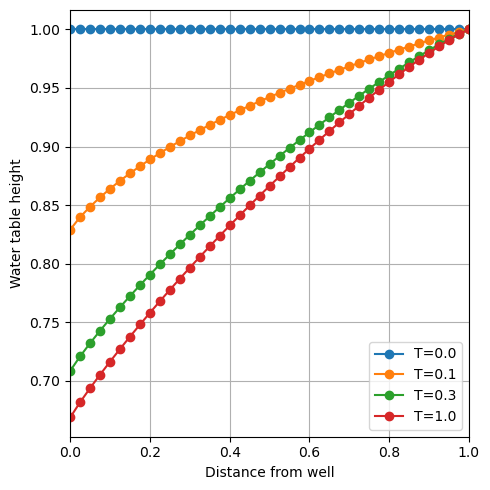

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))


#ax.set_ylim(0.65, 1.01)
ax.set_xlim(0, 1)

ax.plot( boundary_grid.nodes[0, :],  sol[0][eta_mask], 'o-')
ax.plot( boundary_grid.nodes[0, :],  sol[1][eta_mask], 'o-')
ax.plot( boundary_grid.nodes[0, :],  sol[3][eta_mask], 'o-')
ax.plot( boundary_grid.nodes[0, :], sol[-1][eta_mask], 'o-')

ax.set_xlabel('Distance from well')
ax.set_ylabel('Water table height')

ax.legend(['T=0.0', 'T=0.1', 'T=0.3', 'T=1.0'])

ax.grid()

plt.tight_layout()
plt.savefig('moving_darcy_original.eps', format='eps')